In [300]:
import json
import os
os.chdir(os.path.expanduser('~/catkin_ws/src/uwb_v2v_ros_sim/src/'))

import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

from constants import get_topics

# Add path
topics = get_topics(robot_num=2)
dist_topics = [t for t in topics if 'robot_dist' in t]

bagdata_root = os.path.expanduser('~/catkin_ws/src/uwb_v2v_ros_sim/bagdata')
simulations = [dir for dir in os.listdir(bagdata_root) if 'varied_speed' in dir]
max_ranges = [float(simulation.split('_')[-1]) for simulation in simulations]
root_dirs = [os.path.join(bagdata_root, d) for d in simulations if os.path.isdir(os.path.join(bagdata_root, d))]
max_range_root_dirs = sorted(zip(max_ranges, root_dirs), key=lambda x: x[0])
for max_range, dir in max_range_root_dirs:
    print(f'Max range: {max_range}m, directory: {dir}')
    print('')

Max range: 0.0m, directory: /home/hegxiten/catkin_ws/src/uwb_v2v_ros_sim/bagdata/varied_speed_0

Max range: 50.0m, directory: /home/hegxiten/catkin_ws/src/uwb_v2v_ros_sim/bagdata/varied_speed_50

Max range: 100.0m, directory: /home/hegxiten/catkin_ws/src/uwb_v2v_ros_sim/bagdata/varied_speed_100

Max range: 150.0m, directory: /home/hegxiten/catkin_ws/src/uwb_v2v_ros_sim/bagdata/varied_speed_150

Max range: 200.0m, directory: /home/hegxiten/catkin_ws/src/uwb_v2v_ros_sim/bagdata/varied_speed_200

Max range: 250.0m, directory: /home/hegxiten/catkin_ws/src/uwb_v2v_ros_sim/bagdata/varied_speed_250



In [301]:
from scipy.optimize import curve_fit


def calculate_update_rate(df):
    rolling_window_size = 10
    resample_interval_seconds = 1
    df_time_indexed = df.set_index('Time')
    df_time_indexed.index = pd.to_datetime(df_time_indexed.index, unit='s')
    df_resampled = df_time_indexed.resample(f'{resample_interval_seconds}S').size() / resample_interval_seconds  # Now resample and count the entries per second
    df_resampled = df_resampled.rename('Hz')  # Rename the Series to 'Hz'
    # To combine this with the previously resampled DataFrame, 
    df_resampled = pd.concat([df_resampled, df_time_indexed.resample('1S').mean()], axis=1)
    # To convert the index back to float seconds since simulation start
    df_resampled.index = (df_resampled.index - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s')
    df_resampled.index = df_resampled.index.astype(float)
    # Calculate the windowed average of 'Hz' over a the sized time window
    zeros = pd.Series(np.zeros(rolling_window_size - 1))  # create a series of (rolling_window_size - 1) zeros
    hz_with_zeros = pd.concat([zeros, df_resampled['Hz']])  # concatenate zeros and original series
    rolling_avg = hz_with_zeros.rolling(rolling_window_size).mean()  # compute rolling average
    rolling_avg = rolling_avg.iloc[rolling_window_size - 1:]  # remove the first (rolling_window_size - 1) zeros
    df_resampled['Hz (avg)'] = rolling_avg.values  # attach back to the DataFrame
    return df_resampled

def calculate_cutoff_variables(dfs, speed, cut_off_hz):
    # Find the minimum stopping distance at 0.2g deceleration
    stopping_distance = speed**2 / (2 * 0.2 * 9.81)
    # Find tne first index of the distance when Hz (avg) is greater than cut_off_hz
    cut_off_distances = []

    for df_resampled in dfs:
        try:
            cut_off_dist = df_resampled[df_resampled['Hz (avg)'] >= cut_off_hz]['Distance'].iloc[0]
            cut_off_distances.append(cut_off_dist)
        except IndexError:
            print(f'\t\tCould not find cut-off distance for speed {speed} m/s')
    return [speed, sum(cut_off_distances) / len(cut_off_distances) if cut_off_distances else np.nan, stopping_distance]

# Define the form of the function to fit - Exponential Decay Function
def func(x, a, b):
    return a * np.exp(-b * x)

dfs_speed_distance = []
for (max_range, speed_dir) in max_range_root_dirs:
    print(f"Max range: {max_range}m, speed directory: {speed_dir}")
    speeds = [float(speed.split('_')[-1]) for speed in os.listdir(speed_dir)]
    speed_dirs = [os.path.join(speed_dir, d) for d in os.listdir(speed_dir)]
    speed_root_dirs = sorted(zip(speeds, speed_dirs), key=lambda x: x[0])
    varied_speed_data = []  # [speed, cut-off distance, minimum stopping distance]
    for speed, dir in speed_root_dirs:
        bags = sorted(os.listdir(dir))
        print(f"\tSpeed: {speed}m/s, number of bags: {len(bags)}")
        if len(bags) == 0:
            continue
        dfs_resampled_same_speed = []
        for bag in bags:
            bag0_dir = os.path.join(dir, bag)
            if 'active' in bag0_dir:
                continue
            bag = rosbag.Bag(bag0_dir)
            dist_data = []
            init_dist = float('inf')
            for topic, msg, t in bag.read_messages(topics=dist_topics):
                if 'robot1' in topic:
                    distance = json.loads(msg.data)['robot0']
                    # Filter out distance jump-ups (due to vehicle-length)
                    if distance <= init_dist:
                        init_dist = distance
                        dist_data.append([t.to_sec(), distance, speed])
            df = pd.DataFrame(dist_data, columns=['Time', 'Distance', 'Speed'])
            df_resampled = calculate_update_rate(df)
            dfs_resampled_same_speed.append(df_resampled)
        varied_speed_data.append(calculate_cutoff_variables(dfs_resampled_same_speed, speed, cut_off_hz=5))
    
    
    df_speed_distance = pd.DataFrame(varied_speed_data, columns=['Speed', 'Cut-off distance', 'Stopping distance']).dropna()
    if len(df_speed_distance) == 0:
        continue
    # Fit the function to the data to smooth out the curve
    popt, pcov = curve_fit(func, df_speed_distance['Speed'], df_speed_distance['Cut-off distance'])
    # Store the fitted values
    df_speed_distance['Cut-off distance (fitted)'] = func(df_speed_distance['Speed'], *popt)
    dfs_speed_distance.append(df_speed_distance)

Max range: 0.0m, speed directory: /home/hegxiten/catkin_ws/src/uwb_v2v_ros_sim/bagdata/varied_speed_0
	Speed: 0.0m/s, number of bags: 2
		Could not find cut-off distance for speed 0.0 m/s
		Could not find cut-off distance for speed 0.0 m/s
	Speed: 79.0m/s, number of bags: 1
		Could not find cut-off distance for speed 79.0 m/s
	Speed: 80.0m/s, number of bags: 2
		Could not find cut-off distance for speed 80.0 m/s
		Could not find cut-off distance for speed 80.0 m/s
Max range: 50.0m, speed directory: /home/hegxiten/catkin_ws/src/uwb_v2v_ros_sim/bagdata/varied_speed_50
	Speed: 1.0m/s, number of bags: 10
	Speed: 2.0m/s, number of bags: 10
	Speed: 3.0m/s, number of bags: 10
	Speed: 4.0m/s, number of bags: 10
	Speed: 5.0m/s, number of bags: 10
	Speed: 6.0m/s, number of bags: 10
	Speed: 7.0m/s, number of bags: 10
	Speed: 8.0m/s, number of bags: 10
	Speed: 9.0m/s, number of bags: 10
	Speed: 10.0m/s, number of bags: 10
	Speed: 11.0m/s, number of bags: 10
		Could not find cut-off distance for sp

/home/hegxiten/catkin_ws/src/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


	Speed: 2.0m/s, number of bags: 2
	Speed: 3.0m/s, number of bags: 3
	Speed: 4.0m/s, number of bags: 3
	Speed: 5.0m/s, number of bags: 4
	Speed: 6.0m/s, number of bags: 4
	Speed: 7.0m/s, number of bags: 4
	Speed: 8.0m/s, number of bags: 4
	Speed: 9.0m/s, number of bags: 4
	Speed: 10.0m/s, number of bags: 4
	Speed: 11.0m/s, number of bags: 4
	Speed: 12.0m/s, number of bags: 4
	Speed: 13.0m/s, number of bags: 4
	Speed: 14.0m/s, number of bags: 4
	Speed: 15.0m/s, number of bags: 3
	Speed: 16.0m/s, number of bags: 4
	Speed: 17.0m/s, number of bags: 4
	Speed: 18.0m/s, number of bags: 4
	Speed: 19.0m/s, number of bags: 4
	Speed: 20.0m/s, number of bags: 4
	Speed: 21.0m/s, number of bags: 4
	Speed: 22.0m/s, number of bags: 4
	Speed: 23.0m/s, number of bags: 4
	Speed: 24.0m/s, number of bags: 3
	Speed: 25.0m/s, number of bags: 4
	Speed: 26.0m/s, number of bags: 4
	Speed: 27.0m/s, number of bags: 4
	Speed: 28.0m/s, number of bags: 4
	Speed: 29.0m/s, number of bags: 4
	Speed: 30.0m/s, number of b

/home/hegxiten/catkin_ws/src/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


	Speed: 2.0m/s, number of bags: 1
	Speed: 3.0m/s, number of bags: 1
	Speed: 4.0m/s, number of bags: 1
	Speed: 5.0m/s, number of bags: 1
	Speed: 6.0m/s, number of bags: 1
	Speed: 7.0m/s, number of bags: 1
	Speed: 8.0m/s, number of bags: 1
	Speed: 9.0m/s, number of bags: 1
	Speed: 10.0m/s, number of bags: 1
	Speed: 11.0m/s, number of bags: 1
	Speed: 12.0m/s, number of bags: 1
	Speed: 13.0m/s, number of bags: 1
	Speed: 14.0m/s, number of bags: 1
	Speed: 15.0m/s, number of bags: 1
	Speed: 16.0m/s, number of bags: 1
	Speed: 17.0m/s, number of bags: 1
	Speed: 18.0m/s, number of bags: 1
	Speed: 19.0m/s, number of bags: 1
	Speed: 20.0m/s, number of bags: 1
	Speed: 21.0m/s, number of bags: 1
	Speed: 22.0m/s, number of bags: 1
	Speed: 23.0m/s, number of bags: 1
	Speed: 24.0m/s, number of bags: 1
	Speed: 25.0m/s, number of bags: 1
	Speed: 26.0m/s, number of bags: 1
	Speed: 27.0m/s, number of bags: 1
	Speed: 28.0m/s, number of bags: 1
	Speed: 29.0m/s, number of bags: 1
	Speed: 30.0m/s, number of b

/home/hegxiten/catkin_ws/src/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


	Speed: 2.0m/s, number of bags: 1
	Speed: 3.0m/s, number of bags: 1
	Speed: 4.0m/s, number of bags: 1
	Speed: 5.0m/s, number of bags: 1
	Speed: 6.0m/s, number of bags: 1
	Speed: 7.0m/s, number of bags: 1
	Speed: 8.0m/s, number of bags: 1
	Speed: 9.0m/s, number of bags: 1
	Speed: 10.0m/s, number of bags: 1
	Speed: 11.0m/s, number of bags: 1
	Speed: 12.0m/s, number of bags: 1
	Speed: 13.0m/s, number of bags: 1
	Speed: 14.0m/s, number of bags: 1
	Speed: 15.0m/s, number of bags: 1
	Speed: 16.0m/s, number of bags: 1
	Speed: 17.0m/s, number of bags: 1
	Speed: 18.0m/s, number of bags: 1
	Speed: 19.0m/s, number of bags: 1
	Speed: 20.0m/s, number of bags: 1
	Speed: 21.0m/s, number of bags: 1
	Speed: 22.0m/s, number of bags: 1
	Speed: 23.0m/s, number of bags: 1
	Speed: 24.0m/s, number of bags: 1
	Speed: 25.0m/s, number of bags: 1
	Speed: 26.0m/s, number of bags: 1
	Speed: 27.0m/s, number of bags: 1
	Speed: 28.0m/s, number of bags: 1
	Speed: 29.0m/s, number of bags: 1
	Speed: 30.0m/s, number of b

/home/hegxiten/catkin_ws/src/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


	Speed: 2.0m/s, number of bags: 2
	Speed: 3.0m/s, number of bags: 2
	Speed: 4.0m/s, number of bags: 2
	Speed: 5.0m/s, number of bags: 2
	Speed: 6.0m/s, number of bags: 2
	Speed: 7.0m/s, number of bags: 2
	Speed: 8.0m/s, number of bags: 2
	Speed: 9.0m/s, number of bags: 2
	Speed: 10.0m/s, number of bags: 2
	Speed: 11.0m/s, number of bags: 2
	Speed: 12.0m/s, number of bags: 2
	Speed: 13.0m/s, number of bags: 2
	Speed: 14.0m/s, number of bags: 2
	Speed: 15.0m/s, number of bags: 2
	Speed: 16.0m/s, number of bags: 2
	Speed: 17.0m/s, number of bags: 2
	Speed: 18.0m/s, number of bags: 2
	Speed: 19.0m/s, number of bags: 2
	Speed: 20.0m/s, number of bags: 2
	Speed: 21.0m/s, number of bags: 2
	Speed: 22.0m/s, number of bags: 2
	Speed: 23.0m/s, number of bags: 2
	Speed: 24.0m/s, number of bags: 2
	Speed: 25.0m/s, number of bags: 2
	Speed: 26.0m/s, number of bags: 2
	Speed: 27.0m/s, number of bags: 2
	Speed: 28.0m/s, number of bags: 2
	Speed: 29.0m/s, number of bags: 2
	Speed: 30.0m/s, number of b

/home/hegxiten/catkin_ws/src/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[21.96] [122.89541284]


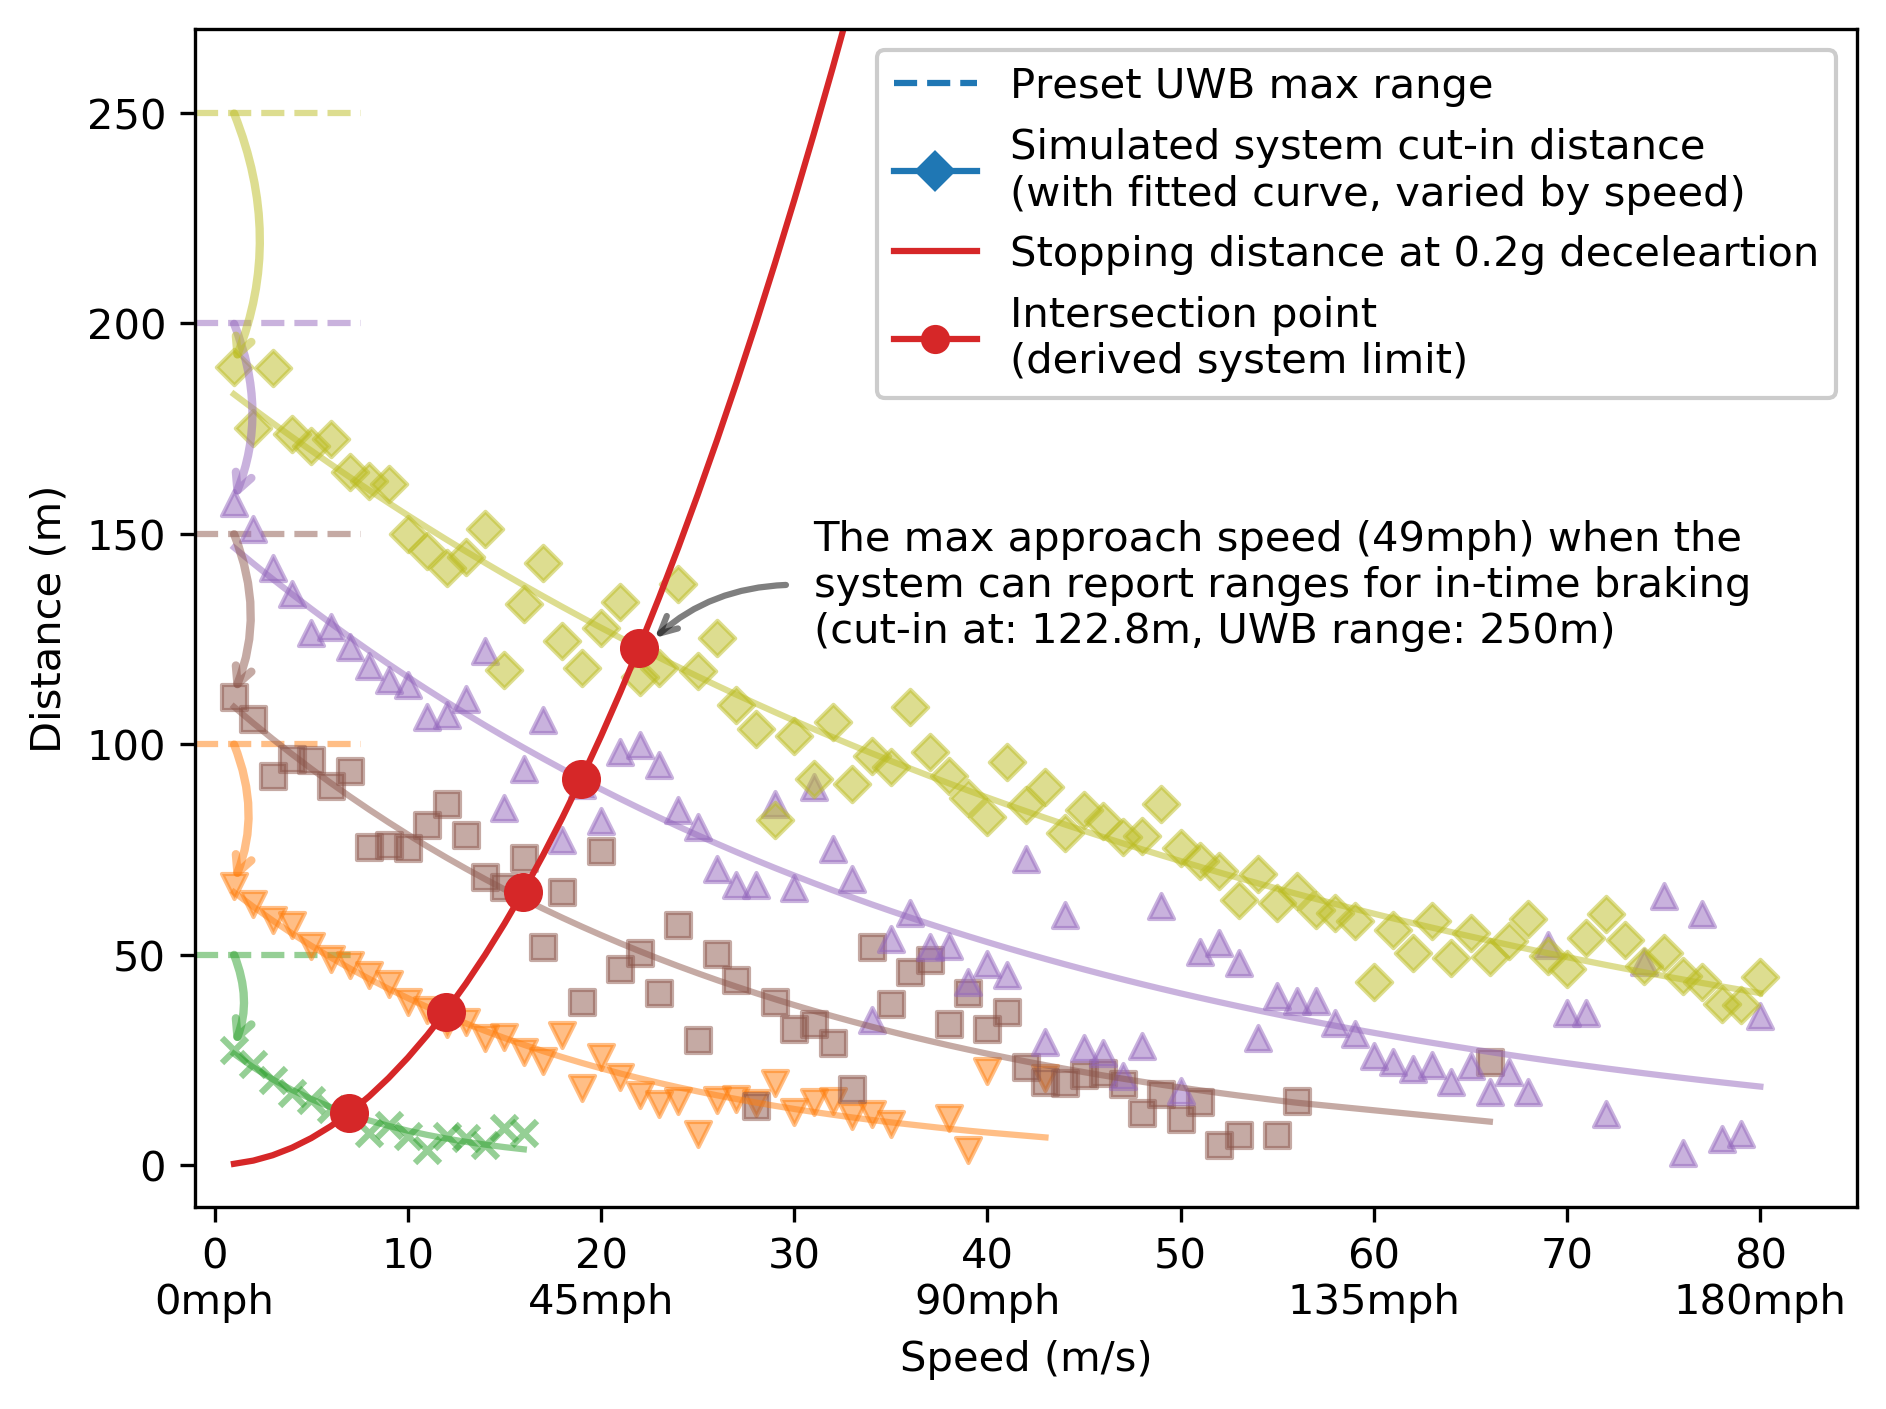

In [315]:
from matplotlib import ticker
from matplotlib.lines import Line2D
import textwrap
# Modify the global DPI setting
plt.rcParams['figure.dpi'] = 300

def round_to_nearest_multiple(num, multiple):
    return round(num / multiple) * multiple

def plot_distance_by_speed(dfs):
    # Create figure and axes
    fig, ax1 = plt.subplots()
    # Resize figure
    # fig.set_size_inches(10, 6)
    
    ax1.set_xlabel('Speed (m/s)')
    ax1.set_ylabel('Distance (m)', )
    ax1.tick_params(axis='y', )

    colors = ['tab:green', 'tab:orange', 'tab:brown', 'tab:purple', 'tab:olive']
    markers = ['x', 'v', 's', '^', 'D']
    alpha = 0.5
    max_ranges = [50, 100, 150, 200, 250]
    legend_elements = []
    # Plot the theoretical stopping distance
    ax1.plot(np.array(dfs[-1]['Speed']), np.array(dfs[-1]['Stopping distance']), color='tab:red')
    for df, color, marker, max_range in zip(dfs, colors, markers, max_ranges): 
        df = df.dropna()
        # Replace the values of Stopping distance larger than 300m as NaN
        # df['Stopping distance'] = df['Stopping distance'].apply(lambda x: x if x < max_range else np.nan)
        x0 = np.array(df['Speed'])[0]
        y0 = np.array(df['Cut-off distance'])[0]
        # Plot the fitted curve of cut-off distances, varied by color
        ax1.plot(np.array(df['Speed']), np.array(df['Cut-off distance (fitted)']), color=color, alpha=alpha)
        # Plot the cut-off distance in scatters, varied by marker
        ax1.scatter(np.array(df['Speed']), np.array(df['Cut-off distance']), color=color, marker=marker, alpha=alpha, zorder=2)
        # Plot the maximum UWB range in simulation settings as a dashed line
        ax1.axhline(y=max_range, xmax=0.1, color=color, linestyle='--', alpha=alpha, zorder=1)
        # ax1.plot([0, x0], [max_range, max_range], color=color, linestyle='-', alpha=alpha)
        # Plot text on top of the dashed line and align left
        # ax1.text(x0 - 7.5, max_range - 12, '{:>4}m'.format(max_range), color=color, alpha=alpha, ha='left')
        # Plot an arrow from the end of dashed line to the first scatter
        ax1.annotate(
            "", xy=(x0, max_range), xytext=(x0, y0 + 1),
            arrowprops=dict(arrowstyle="<-", color=color, alpha=alpha, linewidth=2, shrinkA=0, shrinkB=0.1, connectionstyle="arc3,rad=0.2", ),
            zorder=max_range // 50 + 1
        )
        # calculate the intersection (x, y) coords between the fitted curve and the theoretical stopping distance
        x = np.array(df['Speed'])
        y = np.array(df['Cut-off distance (fitted)'])
        y2 = np.array(df['Stopping distance'])
        idx = np.argwhere(np.diff(np.sign(y - y2))).flatten()
        next_idx = idx + 1
        x_intersect = (x[idx] + (x[next_idx] - x[idx]) / 2) + 0.46
        y_intersect_m = (x_intersect) ** 2 / (2 * 0.2 * 9.81)
        # Plot the intersection point between the fitted curve and the theoretical stopping distance, a large marker
        ax1.scatter(x_intersect, y_intersect_m, color='tab:red', marker='o', s=70, zorder=3)
        if max_range == 250:
            # Plot an arrow from x-axis to the first intersection point
            ax1.annotate(
                "", xy=(30, y_intersect_m + 15), xytext=(x_intersect + 0.5, y_intersect_m + 1),
                arrowprops=dict(arrowstyle="<-", alpha=alpha, linewidth=1.5, connectionstyle="arc3,rad=-0.2", )
                )
            print(x_intersect, y_intersect_m)
            label = 'The max approach speed (49mph) when the system can report ranges for in-time braking (cut-in at: 122.8m, UWB range: 250m)'
            wrapped_label = textwrap.fill(label, 44)
            ax1.text(30 + 1, y_intersect_m + 15, wrapped_label, ha='left', va='center')
    legend_elements.append(Line2D([0], [0], linestyle='--',                                 label='Preset UWB max range'))
    legend_elements.append(Line2D([0], [0], marker=marker,                                  label='Simulated system cut-in distance\n(with fitted curve, varied by speed)'))
    legend_elements.append(Line2D([0], [0], color='tab:red',                                label='Stopping distance at 0.2g deceleartion'))
    legend_elements.append(Line2D([0], [0], marker='o', color='tab:red',                    label='Intersection point\n(derived system limit)'))
    legend = ax1.legend(handles=legend_elements, loc='upper right', facecolor='white', framealpha=1)
    
    # Set y-limits
    ax1.set_ylim([-10, 270])
    # Set x-limits
    ax1.set_xlim([-1, 85])

    # Format the tick text labels
    def custom_formatter(x, pos):
        if x // 10 % 2 == 0:
            return f'{x:.0f}\n{round_to_nearest_multiple(x * 2.23694, 5):.0f}mph'
        else:
            return f'{x:.0f}'
    
    # Create a FuncFormatter using your custom function
    formatter = ticker.FuncFormatter(custom_formatter)
    ax1.xaxis.set_major_formatter(formatter=formatter)

    # Create an untransparent legend both background and frame with untransparent white fill 
    fig.tight_layout()
    plt.show()
plot_distance_by_speed(dfs_speed_distance)


In [303]:
def calculate_update_rate(df):
    rolling_window_size = 10
    resample_interval_seconds = 1
    df_time_indexed = df.set_index('Time')
    df_time_indexed.index = pd.to_datetime(df_time_indexed.index, unit='s')
    df_resampled = df_time_indexed.resample(f'{resample_interval_seconds}S').size() / resample_interval_seconds  # Now resample and count the entries per second
    df_resampled = df_resampled.rename('Hz')  # Rename the Series to 'Hz'
    # To combine this with the previously resampled DataFrame, 
    df_resampled = pd.concat([df_resampled, df_time_indexed.resample('1S').mean()], axis=1)
    # To convert the index back to float seconds since simulation start
    df_resampled.index = (df_resampled.index - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s')
    df_resampled.index = df_resampled.index.astype(float)
    # Calculate the windowed average of 'Hz' over a the sized time window
    zeros = pd.Series(np.zeros(rolling_window_size - 1))  # create a series of (rolling_window_size - 1) zeros
    hz_with_zeros = pd.concat([zeros, df_resampled['Hz']])  # concatenate zeros and original series
    rolling_avg = hz_with_zeros.rolling(rolling_window_size).mean()  # compute rolling average
    rolling_avg = rolling_avg.iloc[rolling_window_size - 1:]  # remove the first (rolling_window_size - 1) zeros
    df_resampled['Hz (avg)'] = rolling_avg.values  # attach back to the DataFrame
    return df_resampled

def calculate_hz_distance_distribution(dfs, speed):    
    # keep only 'Distance' column, 'Hz' column and 'Hz (avg)' column
    dfs = [df[['Distance', 'Hz', 'Hz (avg)']].reset_index(drop=True).dropna() for df in dfs]
    # concat all dfs into one and sort by 'Distance'
    df = pd.concat(dfs).sort_values(by='Distance')
    # aggregate by 'Distance' and calculate mean of 'Hz (avg)'
    df = df.groupby('Distance').mean().reset_index()
    return (speed, df)



for (max_range, speed_dir) in max_range_root_dirs:
    if max_range != 50:
        continue
    print(f"Max range: {max_range}m, speed directory: {speed_dir}")
    speeds = [float(speed.split('_')[-1]) for speed in os.listdir(speed_dir)]
    speed_dirs = [os.path.join(speed_dir, d) for d in os.listdir(speed_dir)]
    speed_root_dirs = sorted(zip(speeds, speed_dirs), key=lambda x: x[0])
    varied_hz_dfs = []
    for speed, dir in speed_root_dirs:
        bags = sorted(os.listdir(dir))
        print(f"\tSpeed: {speed}m/s, number of bags: {len(bags)}")
        if len(bags) == 0:
            continue
        dfs_resampled_same_speed = []
        for bag in bags:
            bag0_dir = os.path.join(dir, bag)
            if 'active' in bag0_dir:
                continue
            bag = rosbag.Bag(bag0_dir)
            dist_data = []
            init_dist = float('inf')
            for topic, msg, t in bag.read_messages(topics=dist_topics):
                if 'robot1' in topic:
                    distance = json.loads(msg.data)['robot0']
                    # Filter out distance jump-ups (due to vehicle-length)
                    if distance <= init_dist:
                        init_dist = distance
                        dist_data.append([t.to_sec(), distance, speed])
            df = pd.DataFrame(dist_data, columns=['Time', 'Distance', 'Speed'])
            df_resampled = calculate_update_rate(df)
            dfs_resampled_same_speed.append(df_resampled)
        varied_hz_dfs.append(calculate_hz_distance_distribution(dfs_resampled_same_speed, speed))


Max range: 50.0m, speed directory: /home/hegxiten/catkin_ws/src/uwb_v2v_ros_sim/bagdata/varied_speed_50
	Speed: 1.0m/s, number of bags: 10
	Speed: 2.0m/s, number of bags: 10
	Speed: 3.0m/s, number of bags: 10
	Speed: 4.0m/s, number of bags: 10
	Speed: 5.0m/s, number of bags: 10
	Speed: 6.0m/s, number of bags: 10
	Speed: 7.0m/s, number of bags: 10
	Speed: 8.0m/s, number of bags: 10
	Speed: 9.0m/s, number of bags: 10
	Speed: 10.0m/s, number of bags: 10
	Speed: 11.0m/s, number of bags: 10
	Speed: 12.0m/s, number of bags: 10
	Speed: 13.0m/s, number of bags: 9
	Speed: 14.0m/s, number of bags: 10
	Speed: 15.0m/s, number of bags: 9
	Speed: 16.0m/s, number of bags: 10
	Speed: 17.0m/s, number of bags: 10
	Speed: 18.0m/s, number of bags: 10
	Speed: 19.0m/s, number of bags: 9
	Speed: 20.0m/s, number of bags: 10
	Speed: 21.0m/s, number of bags: 10
	Speed: 22.0m/s, number of bags: 8
	Speed: 23.0m/s, number of bags: 10
	Speed: 24.0m/s, number of bags: 10
	Speed: 25.0m/s, number of bags: 9
	Speed: 26

In [304]:
# Define the form of the function to fit - Rayleigh
def rayleigh_func(x, a, b, sigma):
    return a * ((x - b) / sigma**2) * np.exp(-(x - b)**2 / (2*sigma**2))


speeds = [1, 5, 10, 20, 30, 40, 50]
dfs_distance_hz = []
for spd in speeds:
    _dfs = []
    for (speed, df) in varied_hz_dfs:
        if speed < spd:
            continue
        _dfs.append(df)
    df = pd.concat(_dfs)
    # Sort by 'Distance'
    df = df.sort_values(by='Distance')
    # Define bin edges for the 'Distance' column
    bins = np.arange(0, df['Distance'].max() + 1, 1)
    # Use the 'cut' function to create bins
    df['Distance_bins'] = pd.cut(df['Distance'], bins, include_lowest=True, right=True, labels=False)
    # Group by the 'Distance_bins' column and aggregate the other columns
    series_resampled = df.groupby('Distance_bins')['Hz'].agg(lambda x: x.quantile(0.95))
    # Fit the function to the data to smooth out the curve
    popt, pcov = curve_fit(rayleigh_func, series_resampled.index, series_resampled.values)
    # make the new df out of the series_resampled 
    df['Hz (fitted)'] = rayleigh_func(df['Distance'], *popt)
    df_resampled = pd.DataFrame({'Distance': series_resampled.index, 'Hz (Aggregated)': series_resampled.values})
    # Store the fitted values
    dfs_distance_hz.append((spd, df, df_resampled))


In [305]:
from matplotlib.lines import Line2D


def round_to_nearest_multiple(num, multiple):
    return round(num / multiple) * multiple

def plot_hz_by_distance(dfs):￼
    # Create figure and axes
    fig, ax1 = plt.subplots()
    # Resize figure
    # fig.set_size_inches(10, 6)
    
    ax1.set_xlabel('Ground Truth V2V Distance (m)')
    ax1.set_ylabel('Update Rate (Hz)', )
    ax1.tick_params(axis='y', )
    
    colors = ['tab:red', 'tab:orange', 'tab:brown', 'tab:purple', 'tab:olive', 'tab:cyan', 'tab:pink']
    markers = ['x', 'v', 's', '^', 'D', 'o', 'P']
    alpha = 0.5
    legend_elements = []
    legend_elements.append(Line2D([0], [0], color='white', linestyle='none', marker='None', label="Stablized update rates \n(P95) after system cut-in\nif approach speed >"))
    for (spd, df, df_resampled), color, marker, in zip(dfs, colors, markers): 
        # Plot the fitted curve of Hz, varied by color
        ax1.plot(np.array(df['Distance']), np.array(df['Hz (fitted)']), color=color, alpha=alpha)
        # Plot the scatter of aggregated Hz, varied by marker
        ax1.scatter(np.array(df_resampled['Distance']), np.array(df_resampled['Hz (Aggregated)']), color=color, marker=marker, alpha=alpha)
        legend_elements.append(Line2D([0], [0], color=color, marker=marker,     label=f'{spd} m/s ({spd * 2.23694:.0f} mph)'))
        
    legend = ax1.legend(handles=legend_elements, loc='upper right', facecolor='white', framealpha=1)

    # Create an untransparent legend both background and frame with untransparent white fill 
    fig.tight_layout()
    plt.show()
plot_hz_by_distance(dfs_distance_hz)

SyntaxError: invalid character in identifier (470136421.py, line 7)